# Generative Adversarial Nets
#### Ian J. Goodfellow et al _Universite de Montreal
In Adversarial training procedure two models are trained together. The generative model, G, that estimates the data distribution and the discriminative model, D, that determines if a given sample has come from the dataset or artificially generated. G is evolved into making artificially generated samples that are with higher probability mistaken by the D model as coming from true data distribution.
One nice property of GANs is that the generator is not directly updated with data examples, but by the gradients coming through the discriminator.
Here we will make a conditional generative model p(x|c) by adding some class label c as input to both G and D.

In [1]:
# Imports
%reload_ext autoreload
%autoreload 1

import os, sys
sys.path.append('../')

from tools_general import tf, np
from IPython.display import Image
from tools_train import get_train_params, OneHot, vis_square
import imageio

In [2]:
# define parameters
networktype = 'DCGAN_MNIST'

work_dir = '../trained_models/%s/' %networktype

## Network definitions

In [3]:
# define networks
from tools_networks import deconv, conv, dense, clipped_crossentropy, dropout

def concat_labels(X, labels):
    if X.get_shape().ndims == 4:
        X_shape = tf.shape(X)
        labels_reshaped = tf.reshape(labels, [-1, 1, 1, 10])
        a = tf.ones([X_shape[0], X_shape[1], X_shape[2], 10])
        X = tf.concat([X, labels_reshaped * a], axis=3)
    return X
     
def create_gan_G(z, labels, is_training, Cout=1, trainable=True, reuse=False, networktype='ganG'):
    '''input : batchsize * 100 and labels to make the generator conditional
        output: batchsize * 28 * 28 * 1'''
    with tf.variable_scope(networktype, reuse=reuse):
        z = tf.concat(axis=-1, values=[z, labels])
        Gz = dense(z, is_training, Dout=4 * 4 * 256, act='reLu', useBN=True, name='dense2')
        Gz = tf.reshape(Gz, shape=[-1, 4, 4, 256])  # 4
        Gz = deconv(Gz, is_training, kernel_w=5, stride=2, Cout=256, trainable=trainable, act='reLu', useBN=True, name='deconv1')  # 11
        Gz = deconv(Gz, is_training, kernel_w=5, stride=2, Cout=128, trainable=trainable, act='reLu', useBN=True, name='deconv2')  # 25
        Gz = deconv(Gz, is_training, kernel_w=4, stride=1, Cout=1, act=None, useBN=False, name='deconv3')  # 28
        Gz = tf.nn.sigmoid(Gz)
    return Gz

def create_gan_D(xz, labels, is_training, trainable=True, reuse=False, networktype='ganD'):
    with tf.variable_scope(networktype, reuse=reuse):
        xz = concat_labels(xz, labels)
        Dxz = conv(xz, is_training, kernel_w=5, stride=2, Cout=128, trainable=trainable, act='lrelu', useBN=False, name='conv1')  # 12
        Dxz = conv(Dxz, is_training, kernel_w=5, stride=2, Cout=256, trainable=trainable, act='lrelu', useBN=True, name='conv2')  # 4
        Dxz = conv(Dxz, is_training, kernel_w=2, stride=2, Cout=256, trainable=trainable, act='lrelu', useBN=True, name='conv3')  # 2
        Dxz = conv(Dxz, is_training, kernel_w=2, stride=2, Cout=1, trainable=trainable, act='lrelu', useBN=True, name='conv4')  # 2
        Dxz = tf.nn.sigmoid(Dxz)
    return Dxz

def create_gan_trainer(base_lr=1e-4, networktype='gan'):
    '''Train a Generative Adversarial Network'''
    # with tf.name_scope('train_%s' % networktype): 
    is_training = tf.placeholder(tf.bool, [], 'is_training')

    inZ = tf.placeholder(tf.float32, [None, 100])  # tf.random_uniform(shape=[batch_size, 100], minval=-1., maxval=1., dtype=tf.float32)
    inL = tf.placeholder(tf.float32, [None, 10])  # we want to condition the generated out put on some parameters of the input
    inX = tf.placeholder(tf.float32, [None, 28, 28, 1])

    Gz = create_gan_G(inZ, inL, is_training, Cout=1, trainable=True, reuse=False, networktype=networktype + '_G') 

    DGz = create_gan_D(Gz, inL, is_training, trainable=True, reuse=False, networktype=networktype + '_D')
    Dx = create_gan_D(inX, inL, is_training, trainable=True, reuse=True, networktype=networktype + '_D')
    
    ganG_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=networktype + '_G')
    #print(len(ganG_var_list), [var.name for var in ganG_var_list])

    ganD_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=networktype + '_D')
    #print(len(ganD_var_list), [var.name for var in ganD_var_list])
          
    Gscore = clipped_crossentropy(DGz, tf.ones_like(DGz))
    Dscore = clipped_crossentropy(DGz, tf.zeros_like(DGz)) + clipped_crossentropy(Dx, tf.ones_like(Dx))
    
    Gtrain = tf.train.AdamOptimizer(learning_rate=base_lr, beta1=0.5).minimize(Gscore, var_list=ganG_var_list)
    Dtrain = tf.train.AdamOptimizer(learning_rate=base_lr, beta1=0.5).minimize(Dscore, var_list=ganD_var_list)
    
    return Gtrain, Dtrain, Gscore, Dscore, is_training, inZ, inX, inL, Gz

## Adversarial Training
The following cell type can be turned into code and used for training DCGAN. But i used the console code and saved results in best model directory. 

batch_size = 128
base_lr = 0.0002  # 1e-4
epochs = 10

data_dir = '../data/'
work_dir = '../reseults/%s/20170707/' %networktype

if not os.path.exists(work_dir): os.makedirs(work_dir)

data, max_iter, test_iter, test_int, disp_int = get_train_params(data_dir + '/' + networktype, 
                                                                 batch_size, epochs, networktype=networktype)
tf.reset_default_graph() 
with tf.Session() as sess:

    Gtrain, Dtrain, Gscore, Dscore, is_training, inZ, inX, inL, Gz = create_gan_trainer(base_lr, networktype=networktype)
    tf.global_variables_initializer().run()

    var_list = [var for var in tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES) 
                if (networktype.lower() in var.name.lower()) and ('adam' not in var.name.lower())]  
    saver = tf.train.Saver(var_list=var_list, max_to_keep = 1000)
    # saver.restore(sess, expr_dir + 'ganMNIST/20170707/214_model.ckpt')  

    Z_test = np.random.uniform(size=[batch_size, 100], low=-1., high=1.).astype(np.float32)
    labels_test = OneHot(np.random.randint(10, size=[batch_size]), n=10)    

    k = 1

    for it in range(1, max_iter):
        Z = np.random.uniform(size=[batch_size, 100], low=-1., high=1.).astype(np.float32)
        X, labels = data.train.next_batch(batch_size)

        for itD in range(k):
            cur_Gscore, _ = sess.run([Gscore, Gtrain], feed_dict={inZ:Z, inL:labels, is_training:True})

        cur_Dscore, _ = sess.run([Dscore, Dtrain], feed_dict={inX:X, inZ:Z, inL:labels, is_training:True})

        if it % disp_int == 0:
            Gz_sample = sess.run(Gz, feed_dict={inZ: Z_test, inL: labels_test, is_training:False})
            vis_square(Gz_sample[:121], [11, 11], save_path=work_dir + 'Iter_%d.jpg' % it)
            saver.save(sess, work_dir + "%4d_model.ckpt" % it)
            if ('cur_Dscore' in vars()) and ('cur_Gscore' in vars()):
                print("Iteration #%4d, Train Gscore = %f, Dscore=%f" % (it, cur_Gscore, cur_Dscore))

I will later look into what if we make our noise gaussian (and make some samples more frquent)?

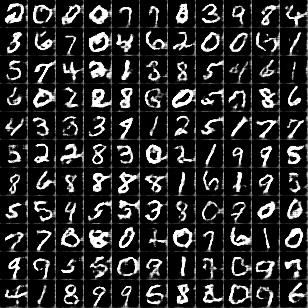

In [4]:
best_iter = 85814#visually selected
best_img = work_dir + 'Iter_%d.jpg' %best_iter
best_ganMNIST_model = work_dir + "%.3d_model.ckpt" % best_iter
Image(filename=best_img)

## Experiments
Create demo networks and restore weights

In [5]:
tf.reset_default_graph() 
demo_sess = tf.InteractiveSession()

is_training = tf.placeholder(tf.bool, [], 'is_training')

inZ = tf.placeholder(tf.float32, [None, 100])
inL = tf.placeholder(tf.float32, [None, 10])
inX = tf.placeholder(tf.float32, [None, 28, 28, 1])

Gz = create_gan_G(inZ, inL, is_training, Cout=1, trainable=True, reuse=False, networktype=networktype + '_G') 

DGz = create_gan_D(Gz, inL, is_training, trainable=True, reuse=False, networktype=networktype + '_D')
    
tf.global_variables_initializer().run()

ganG_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=networktype + '_G')
saver = tf.train.Saver(var_list=ganG_var_list)
saver.restore(demo_sess, best_ganMNIST_model) 

INFO:tensorflow:Restoring parameters from ../trained_models/DCGAN_MNIST/85814_model.ckpt


### 1) Sample bag of numbers from the generator

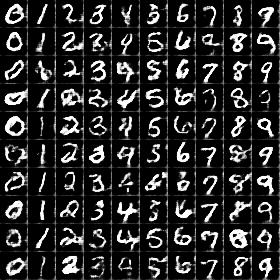

In [6]:
batch_size = 100
desired_number = 0
Z_test = np.random.uniform(size=[batch_size, 100], low=-1., high=1.).astype(np.float32)
labels_test = OneHot(np.repeat([[0,1,2,3,4,5,6,7,8,9]],batch_size//10,axis=0))
#labels_test = OneHot(np.repeat([[0,1,0,1,0,1,0,1,0,1]],batch_size//10,axis=0))

Gz_sample = demo_sess.run(Gz, feed_dict={inZ: Z_test, inL: labels_test, is_training:False})
img = vis_square(Gz_sample, [batch_size//10, 10],save_path=work_dir + 'test.jpg')
Image(filename=work_dir + 'test.jpg')

### 2) Sample single number from the generator

In [7]:
num = 3
Z1 = np.random.uniform(size=[1, 100], low=-1., high=1.).astype(np.float32)
L1 = OneHot(np.repeat([[num]],1,axis=1))
Gz_sample = demo_sess.run(Gz, feed_dict={inZ: Z1, inL: L1, is_training:False})
img = vis_square(Gz_sample, [1, 1],save_path=work_dir + 'test.jpg')
Image(filename=work_dir + 'test.jpg')


### 3) Class Sweep
With the same z slowly move the class labels to smoothly generate different numbers

In [8]:
class_sweep_dir = work_dir+'class_sweep/'
if not os.path.exists(class_sweep_dir): os.makedirs(class_sweep_dir)
batch_size = 100
Z_test = np.random.uniform(size=[batch_size, 100], low=-1., high=1.).astype(np.float32)
images = []
for num in range(9):
    for p in np.linspace(1.,0.,50):
        count=len(images)
        fname = class_sweep_dir+ '%.2d_%d_%.2f.jpg'%(count,num,p)

        labels_test = OneHot(np.repeat([[0,0,0,0,0,0,0,0,0,0]],batch_size//10,axis=0))
        for i in range(batch_size): labels_test[i,num] = p; labels_test[i,num+1] = 1-p

        Gz_sample = demo_sess.run(Gz, feed_dict={inZ: Z_test, inL: labels_test, is_training:False})
        img = vis_square(Gz_sample, [batch_size//10, 10],save_path= fname)
        images.append(imageio.imread(fname))
        try: os.remove(fname)
        except: pass
        
imageio.mimsave(class_sweep_dir+'class_sweep.gif', images)
display(Image(url=class_sweep_dir+'class_sweep.gif'))

### 3) Z-space Sweep
Vary a coefficient alpha that determines how much of two different Z values are used to sample from the generator.
This is also called interpolation in z space in the original paper.

In [9]:
zspace_sweep_dir = work_dir+'zspace_sweep/'
if not os.path.exists(zspace_sweep_dir): os.makedirs(zspace_sweep_dir)
batch_size = 100

Z1 = np.random.uniform(size=[batch_size, 100], low=-1., high=1.).astype(np.float32)
Z2 = np.random.uniform(size=[batch_size, 100], low=-1., high=1.).astype(np.float32)

images = []
for alpha in np.linspace(1.,0.,50):
    count=len(images)
    fname = zspace_sweep_dir+'%.2d.jpg'%(count)
    
    Z_test = alpha * Z1 + (1-alpha)*Z2
    labels_test = OneHot(np.repeat([[0,1,2,3,4,5,6,7,8,9]],batch_size//10,axis=0))
    
    Gz_sample = demo_sess.run(Gz, feed_dict={inZ: Z_test, inL: labels_test, is_training:False})
    img = vis_square(Gz_sample, [batch_size//10, 10],save_path=fname)
    images.append(imageio.imread(fname))
    try: os.remove(fname)
    except: pass
    
imageio.mimsave(zspace_sweep_dir+'zspace_sweep_all.gif', images)
display(Image(url=zspace_sweep_dir+'zspace_sweep_all.gif'))